In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import drive
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from tqdm.notebook import tqdm
from numba import jit
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
#connect drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#unpack zip from drive
with zipfile.ZipFile("drive/MyDrive/clean_data.zip","r") as zip_ref:
    zip_ref.extractall("./")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
disease_lables = ('Bactiral Pneunomia', 'Viral Pneunomia')
normal_lable = ('Normal')
def to_location_modified(target):
    NUM_CLASS = len(disease_lables) + 1 
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [ ]:
#data aug
train_data_path = "data/train"
test_data_path = "data/test"
BATCH_SIZE = 32

train_transforms = transforms.Compose([transforms.Resize((150, 150)),transforms.Grayscale(),
                                       transforms.ToTensor(),transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),transforms.RandomRotation(45)])

test_transforms = transforms.Compose([transforms.Resize((150,150)),transforms.Grayscale(),transforms.ToTensor()])


train_data = datasets.ImageFolder(train_data_path, transform=train_transforms, target_transform=to_location_modified)
test_data = datasets.ImageFolder(test_data_path, transform=test_transforms, target_transform=to_location_modified)

In [ ]:
#load test/train data
train_dl = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

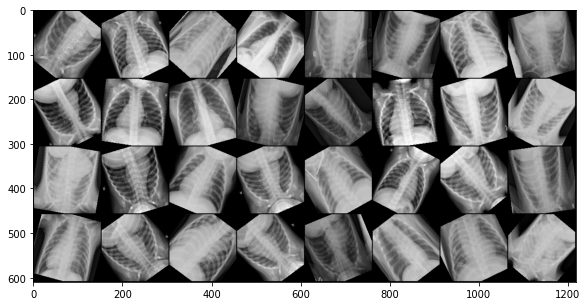

In [ ]:
plt.figure(figsize=(15,5))
images, labels = iter(train_dl).next()
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, n_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 4096),
			nn.ReLU(),
			nn.Dropout(.5),
			nn.Linear(4096, 4096),
			nn.ReLU(),
			nn.Dropout(.5),
			nn.Linear(4096, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = CNN(input_channels=1, n_classes=3).to(device)

In [ ]:
model.conv_layers(images[:1].to(device)).size()


torch.Size([1, 128, 5, 5])

In [ ]:
summary(model,(1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             160
              ReLU-2         [-1, 16, 148, 148]               0
       BatchNorm2d-3         [-1, 16, 148, 148]              32
            Conv2d-4         [-1, 16, 146, 146]           2,320
              ReLU-5         [-1, 16, 146, 146]               0
       BatchNorm2d-6         [-1, 16, 146, 146]              32
         MaxPool2d-7           [-1, 16, 73, 73]               0
            Conv2d-8           [-1, 32, 71, 71]           4,640
              ReLU-9           [-1, 32, 71, 71]               0
      BatchNorm2d-10           [-1, 32, 71, 71]              64
           Conv2d-11           [-1, 32, 69, 69]           9,248
             ReLU-12           [-1, 32, 69, 69]               0
      BatchNorm2d-13           [-1, 32, 69, 69]              64
        MaxPool2d-14           [-1, 32,

In [ ]:
def val(data_dl, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_dl:
            images = images.to(device)
            outputs = model(images)
            for out, label in zip(outputs, labels):
                if torch.argmax(out) == torch.argmax(label):
                    correct += 1
                
            total += len(outputs)
        acc = correct/total
        return acc
print(val(test_dl, model))

0.3333333333333333


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

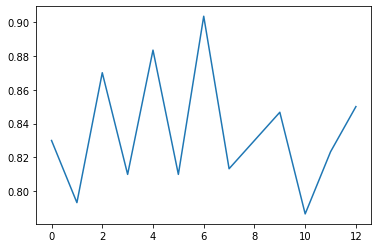


### EPOCH: 1, MeanLoss: 0.24531750501348423, Test Acc: 0.87




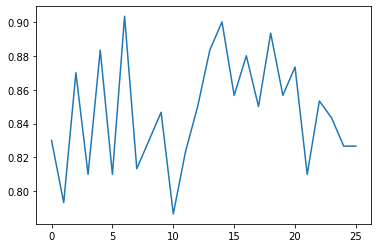


### EPOCH: 2, MeanLoss: 0.24656326254973046, Test Acc: 0.8466666666666667




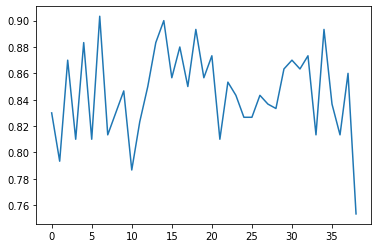


### EPOCH: 3, MeanLoss: 0.23916369390029174, Test Acc: 0.8433333333333334




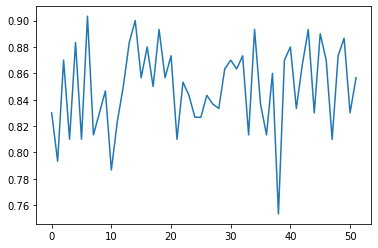


### EPOCH: 4, MeanLoss: 0.24400136831861277, Test Acc: 0.8666666666666667




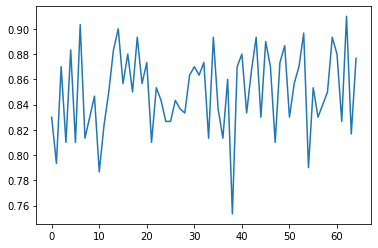


### EPOCH: 5, MeanLoss: 0.23903807218258197, Test Acc: 0.8833333333333333




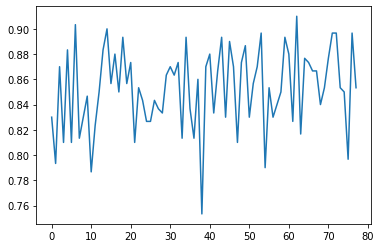


### EPOCH: 6, MeanLoss: 0.23676751370613391, Test Acc: 0.82





test acc 0.9  loss:  0.09481286257505417  saving model...



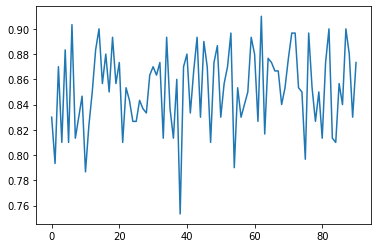


### EPOCH: 7, MeanLoss: 0.2408714109315322, Test Acc: 0.8733333333333333




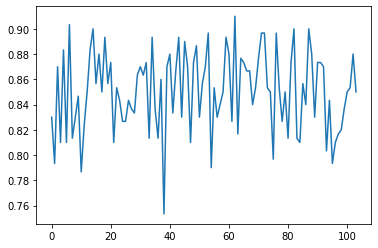


### EPOCH: 8, MeanLoss: 0.23143108383967326, Test Acc: 0.75




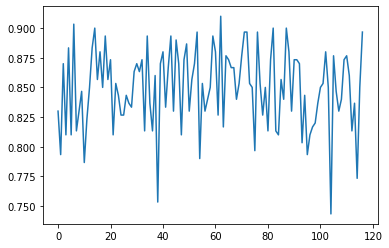


### EPOCH: 9, MeanLoss: 0.23211367691938695, Test Acc: 0.8733333333333333




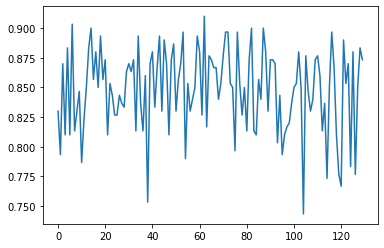


### EPOCH: 10, MeanLoss: 0.23548633479155026, Test Acc: 0.8766666666666667




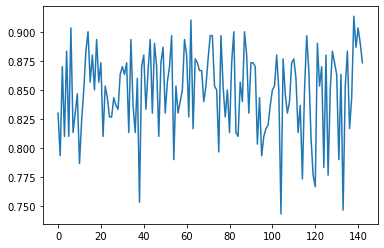


### EPOCH: 11, MeanLoss: 0.2277379372372077, Test Acc: 0.91




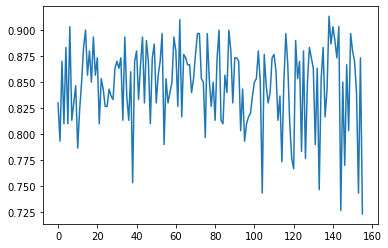


### EPOCH: 12, MeanLoss: 0.2265926789205808, Test Acc: 0.8566666666666667





test acc 0.9066666666666666  loss:  0.0808848887681961  saving model...



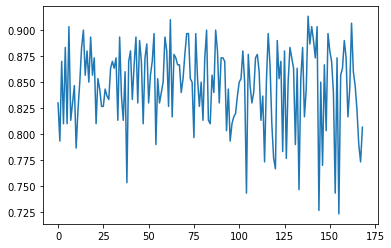


### EPOCH: 13, MeanLoss: 0.2269097747711035, Test Acc: 0.8633333333333333




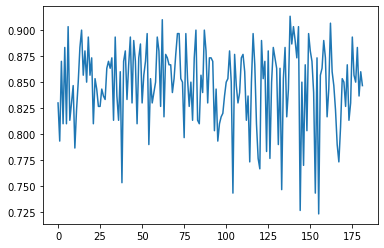


### EPOCH: 14, MeanLoss: 0.2261895089195325, Test Acc: 0.88




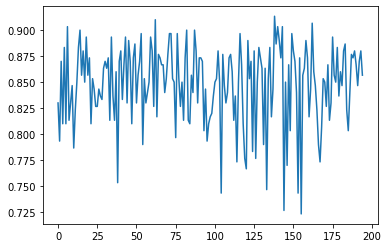


### EPOCH: 15, MeanLoss: 0.22409667258079236, Test Acc: 0.81




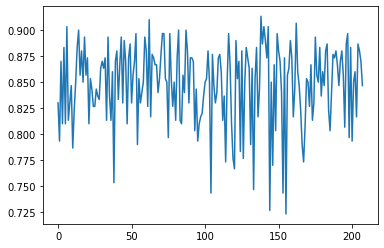


### EPOCH: 16, MeanLoss: 0.22082132731492704, Test Acc: 0.8766666666666667




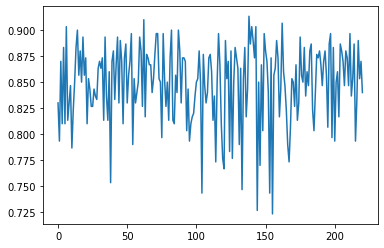


### EPOCH: 17, MeanLoss: 0.21521848038985178, Test Acc: 0.8966666666666666




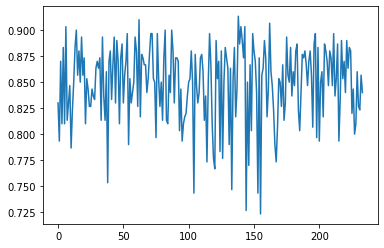


### EPOCH: 18, MeanLoss: 0.21272273206940065, Test Acc: 0.8433333333333334




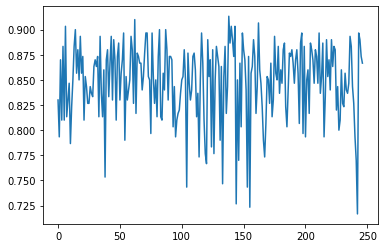


### EPOCH: 19, MeanLoss: 0.21690129219339443, Test Acc: 0.8466666666666667




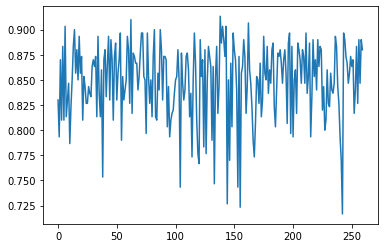


### EPOCH: 20, MeanLoss: 0.20986253533225793, Test Acc: 0.85




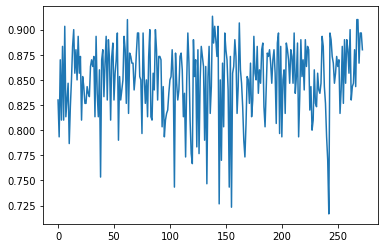


### EPOCH: 21, MeanLoss: 0.2067693461592381, Test Acc: 0.8566666666666667




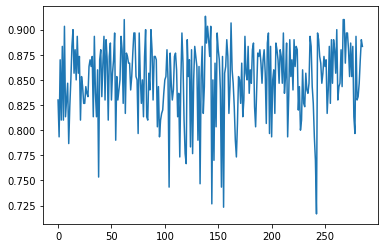


### EPOCH: 22, MeanLoss: 0.2133691089084515, Test Acc: 0.8866666666666667




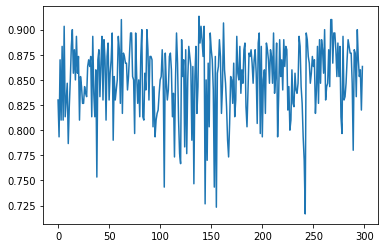


### EPOCH: 23, MeanLoss: 0.21300445009882635, Test Acc: 0.81




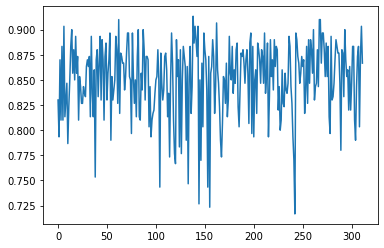


### EPOCH: 24, MeanLoss: 0.19985633151462445, Test Acc: 0.8966666666666666




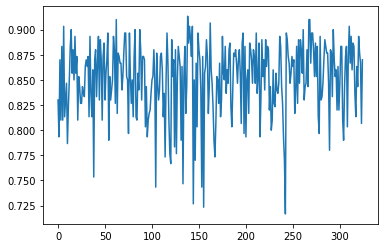


### EPOCH: 25, MeanLoss: 0.20419946295710711, Test Acc: 0.8666666666666667




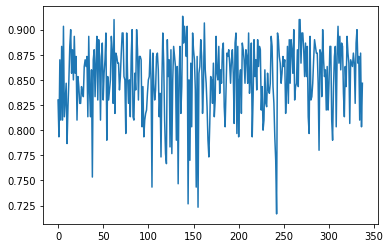


### EPOCH: 26, MeanLoss: 0.2072103133568397, Test Acc: 0.91




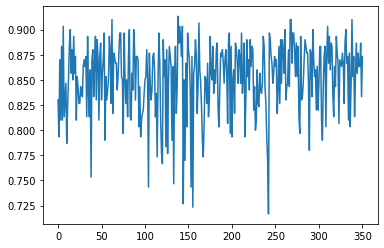


### EPOCH: 27, MeanLoss: 0.2071249506221368, Test Acc: 0.8133333333333334




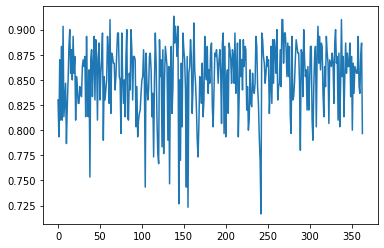


### EPOCH: 28, MeanLoss: 0.20250836037672482, Test Acc: 0.8633333333333333




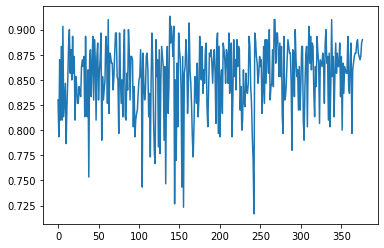


### EPOCH: 29, MeanLoss: 0.18846778376744344, Test Acc: 0.89




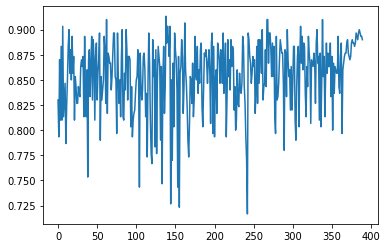


### EPOCH: 30, MeanLoss: 0.17281608802194778, Test Acc: 0.8933333333333333




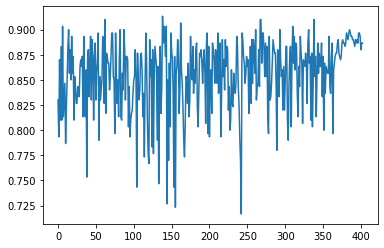


### EPOCH: 31, MeanLoss: 0.17414262220263482, Test Acc: 0.8833333333333333




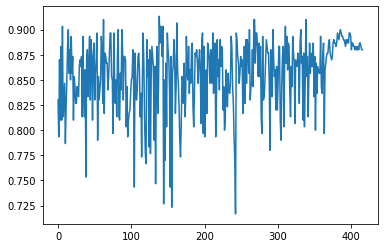


### EPOCH: 32, MeanLoss: 0.169710820254225, Test Acc: 0.8766666666666667




In [ ]:
EPOCHS = 32
test_accs = []
losses = []
max_acc = 0

for epoch in range(EPOCHS):
    losses_sh = []
    for i, (images, labels) in tqdm(enumerate(train_dl)):
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        nn.functional.one_hot(preds.argmax(1), 3)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        losses.append(loss.item())
        losses_sh.append(loss.item())

        if i%10 == 0:
            test_acc = val(test_dl, model)
            test_accs.append(test_acc)
            if test_acc >= .87 and test_acc > max_acc and loss.item() < 0.1:
                max_acc = test_acc
                model.cpu()
                print('\ntest acc', test_acc, ' loss: ', loss.item(), ' saving model...')
                torch.save(model, f"drive/MyDrive/MINI_proj/{test_acc}_loss{loss.item():.3f}.pt")
                model.cuda()

    mean_loss = sum(losses_sh)/len(losses_sh)
    scheduler.step(mean_loss)

    test_acc = val(test_dl, model)
    plt.plot(test_accs)
    plt.show()

    print(f"\n### EPOCH: {epoch+1}, MeanLoss: {mean_loss}, Test Acc: {test_acc}\n\n")